# Impact of Symmetry on State Prediction Using Quantum Numbers with Kernel Ridge Regression and Random Forest Regression  

### 1.1 Importing Libraries 

In [3]:
# Importing Core Libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Importing Machine Learning Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## 1.2 Downloading and Saving Data

In [5]:
# Download the MARVEL dataset for C2H2
import requests
url = 'http://kkrk.chem.elte.hu/marvelonline/data_files/C2H2_energylevels_2019-03-20.txt'
response = requests.get(url)
file_name = 'C2H2_energylevels.txt'

if response.status_code == 200:
    with open(file_name, 'wb') as file:
        file.write(response.content)
        print('File Downloaded Successfully')
else:
        print('Failed to Download File')

File Downloaded Successfully


### Exploratory Data Analysis (EDA)

In [6]:
# Loading the dataset into panda frame
df = pd.read_csv('C2H2_energylevels.txt', sep=r'\s+')
print(df.head())
print('\nShape of the DataSet:')
print(df.shape)

   v1  v2  v3  v4  l4  v5  l5  k  J ef     op      Energy       Unc  NumTrans  \
0   0   0   0   0   0   0   0  0  1  e  ortho    2.353286  0.000000       204   
1   0   0   0   0   0   0   0  0  3  e  ortho   14.119512  0.000041       289   
2   0   0   0   0   0   0   0  0  5  e  ortho   35.297925  0.000042       306   
3   0   0   0   0   0   0   0  0  7  e  ortho   65.887099  0.000043       298   
4   0   0   0   0   0   0   0  0  9  e  ortho  105.885007  0.000043       306   

  u/g           Sym  
0   g  sigma_g_plus  
1   g  sigma_g_plus  
2   g  sigma_g_plus  
3   g  sigma_g_plus  
4   g  sigma_g_plus  

Shape of the DataSet:
(11213, 16)


The data contains 7 vibrational quantum numbers (v1, v2, v3, v4, v5, l4, l5), two rotational numbers (k, J), and some symmetry numbers (ef, op, u/g and symm). 
- **v1, v2, v3, v4, l4, v5, l5:** Quantum numbers representing vibrational or rotational states.
- **k:** Likely a rotational quantum number.
- **J:** Total angular momentum quantum number.
- **ef:** Parity (e or f) or electronic state.
- **op:** Symmetry or spin designation (e.g., ortho/para).
- **Energy:** Energy of the state in arbitrary units (often cm 1 or eV).
- **Unc:** Uncertainty in the energy value.
- **NumTrans:** Number of transitions involving this state.
- **u/g:** Symmetry under inversion (ungerade = u, gerade = g).
- **Sym:** Full symmetry label, such as irreducible representation of the state.

## 1.3 Preprocessing 

In [5]:
# Look for missing values in columns 
print(df.isnull().sum())

v1          0
v2          0
v3          0
v4          0
l4          0
v5          0
l5          0
k           0
J           0
ef          0
op          0
Energy      0
Unc         0
NumTrans    0
u/g         0
Sym         0
dtype: int64


In [6]:
# Removing rows with -ve values in columns
columns_to_check = ['v1', 'v2', 'v3', 'v4', 'l4', 'v5', 'l5', 'k', 'J']
mask = (df[columns_to_check] >= 0).all(axis=1) 
cleaned_df = df[mask]

### Defining the Feature Sets
**Feature Sets**
1. Feature Sets 1 (X1) : Vibrational and rotational quantum numbers
2. Feature Sets 2 (X2) : Feature set 1 plus symmetry numbers

In [7]:
X1 = cleaned_df[['v1', 'v2', 'v3', 'v4', 'l4', 'v5', 'l5', 'k', 'J']]
X2 = cleaned_df[['v1', 'v2', 'v3', 'v4', 'l4', 'v5', 'l5', 'k', 'J', 'ef', 'op', 'u/g', 'Sym']]

#TARGET variable: Energy Levels
Y = cleaned_df['Energy']

print(X1.head())
print(X2.head())
print(Y.head())

   v1  v2  v3  v4  l4  v5  l5  k  J
0   0   0   0   0   0   0   0  0  1
1   0   0   0   0   0   0   0  0  3
2   0   0   0   0   0   0   0  0  5
3   0   0   0   0   0   0   0  0  7
4   0   0   0   0   0   0   0  0  9
   v1  v2  v3  v4  l4  v5  l5  k  J ef     op u/g           Sym
0   0   0   0   0   0   0   0  0  1  e  ortho   g  sigma_g_plus
1   0   0   0   0   0   0   0  0  3  e  ortho   g  sigma_g_plus
2   0   0   0   0   0   0   0  0  5  e  ortho   g  sigma_g_plus
3   0   0   0   0   0   0   0  0  7  e  ortho   g  sigma_g_plus
4   0   0   0   0   0   0   0  0  9  e  ortho   g  sigma_g_plus
0      2.353286
1     14.119512
2     35.297925
3     65.887099
4    105.885007
Name: Energy, dtype: float64


In [8]:
# One Hot Encoding
X2_hot_encoded = pd.get_dummies(X2, columns=['ef', 'op', 'u/g', 'Sym'], drop_first=True)
# print(X2_hot_encoded.head())

### Scaling the Data 

In [11]:
scaler_X = StandardScaler()
X1_scaled = scaler_X.fit_transform(X1)
X2_scaled = scaler_X.fit_transform(X2_hot_encoded)

## 1.4 Splitting the Data Set into Training and Test 

In [12]:
X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, Y,test_size=0.25, random_state=42) 
X2_train, X2_test, y_train, y_test = train_test_split(X2_scaled, Y,test_size=0.25, random_state=42)

In [13]:
# Check dataset shapes to confirm proper splitting
print("\nFeature Set 1:")
print(f"Training set shape: {X1_train.shape}, Testing set shape: {X1_test.shape}")

print("\nFeature Set 2:")
print(f"Training set shape: {X2_train.shape}, Testing set shape: {X2_test.shape}")


Feature Set 1:
Training set shape: (6300, 9), Testing set shape: (2100, 9)

Feature Set 2:
Training set shape: (6300, 20), Testing set shape: (2100, 20)


## 1.5 Kernal Ridge Regression Model and Evaluation

### 1.5.1 Without Symmetry

In [14]:
# Search for the best parameters
from sklearn.model_selection import GridSearchCV
param_grid_krr = {
    'alpha': [0.000001, 0.00001, 0.0001, 0.001], 
    'gamma': [0.001, 0.01, 0.1, 1.0],
    'kernel': ['rbf', 'linear']
}
grid_krr = GridSearchCV(KernelRidge(), param_grid_krr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_krr.fit(X1_train, y_train)
print("Best KRR Parameters:", grid_krr.best_params_)

Best KRR Parameters: {'alpha': 1e-06, 'gamma': 0.01, 'kernel': 'rbf'}


In [15]:
# model KRR trained without symmetry features
krr_model1 = KernelRidge(kernel='rbf', alpha=0.000001, gamma=0.01)
krr_model1.fit(X1_train, y_train) 
y_pred1 = krr_model1.predict(X1_test)

In [16]:
# Evaluation using Mean Squared Error and R Square
mse1 = mean_squared_error(y_test, y_pred1)
r2_1 = r2_score(y_test, y_pred1)
mae1 = mean_absolute_error(y_test, y_pred1)
print('\nEvaluation of KRR without Symmetry\n')
print(f'Mean squared error: {mse1:.3f}')
print(f'R2: {r2_1:.3f}')
print(f'Mean absolute error: {mae1:.3f}')


Evaluation of KRR without Symmetry

Mean squared error: 3.940
R2: 1.000
Mean absolute error: 1.144


### Description: 
The data units are in cm^-1. After converting units into eV for mean squared error (MSE) and mean absolute error (MAE), the required chemical acccuracy is attained.  

In [17]:
mse = 3.940 
mae = 1.144  

# Conversion factor
conversion_factor = 1.2398e-4
mae_eV = mae * conversion_factor
mse_eV = (mse**0.5) * conversion_factor

print("\nConverted Values\n")
print(f"MSE in eV: {mse_eV:.6f} eV")
print(f"MAE in eV: {mae_eV:.6f} eV")


Converted Values

MSE in eV: 0.000246 eV
MAE in eV: 0.000142 eV


### 1.5.2 With Symmetry

In [20]:
# Initialise Krr Model with symmetry 
krr_model2 = KernelRidge(kernel='rbf', alpha=0.000001, gamma=0.01)
# Model Fitting 
krr_model2.fit(X2_train, y_train)
# Make Predictions 
y_pred2 = krr_model2.predict(X2_test)

In [21]:
# Evaluation using Mean Squared Error and R Square
mse2 = mean_squared_error(y_test, y_pred2)
r2_2 = r2_score(y_test, y_pred2)
mae2 = mean_absolute_error(y_test, y_pred2)
print('\nEvaluation of Krr with Symmetry\n')
print(f'Mean squared error: {mse2:.3f}')
print(f'R2: {r2_2:.3f}')
print(f'Mean absolute error: {mae2:.3f}')

# Convert MAE and MSE to eV to check accuracy requirement in eV 
mse2_eV = (mse2**0.5) * 1.2398e-4  # Square root for MSE
mae2_eV = mae2 * 1.2398e-4    

print(f"\nConverted Values:\n")
print(f"MSE in eV: {mse2_eV:.6f} eV")
print(f"MAE in eV: {mae2_eV:.6f} eV")


Evaluation of Krr with Symmetry

Mean squared error: 0.247
R2: 1.000
Mean absolute error: 0.275

Converted Values:

MSE in eV: 0.000062 eV
MAE in eV: 0.000034 eV


## 1.6 Prediction Plots

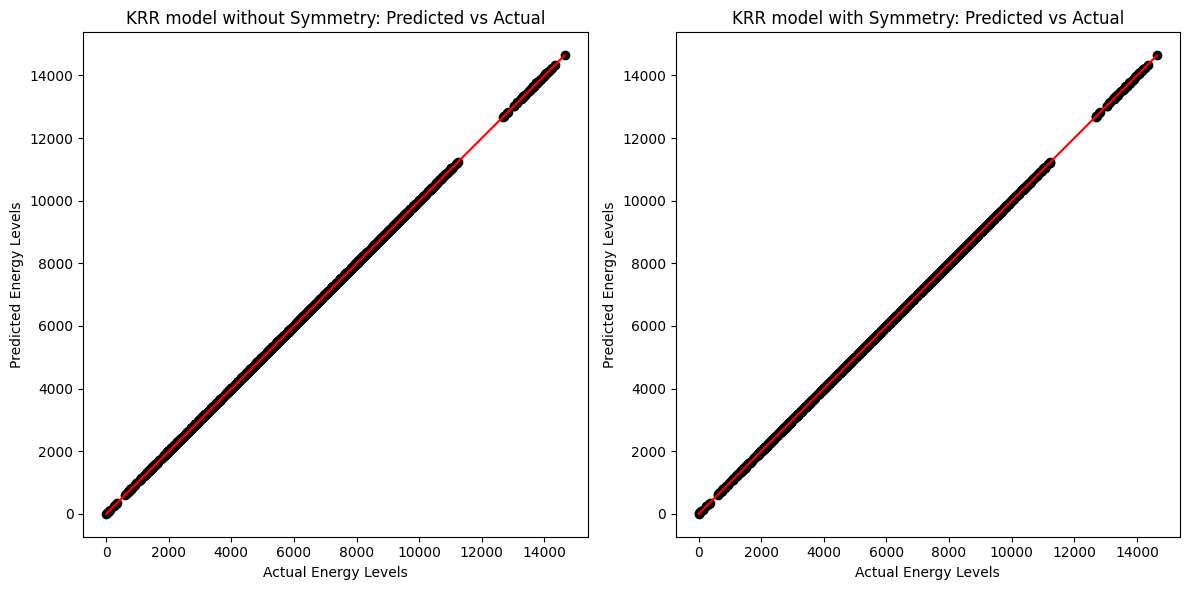

In [22]:
# Model 1 Predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred1, alpha=1.0, color='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title('KRR model without Symmetry: Predicted vs Actual')
plt.xlabel('Actual Energy Levels')
plt.ylabel('Predicted Energy Levels')

# Model 2 Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred2, alpha=1.0, color='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title('KRR model with Symmetry: Predicted vs Actual')
plt.xlabel('Actual Energy Levels')
plt.ylabel('Predicted Energy Levels')

plt.tight_layout()
plt.show()


### Description: 
By looking into the values of evaluation parameters, both Kernel regression models fits perfectly well with R squared values reaching 1. There is only slightly difference between MAE and MSE of the two models. Here Model with symmetry features seems to perform well, one can also look into graph visual for smoother fit. However, both models meet chemical accuracy requirement.

## 1.7 Clustsering 

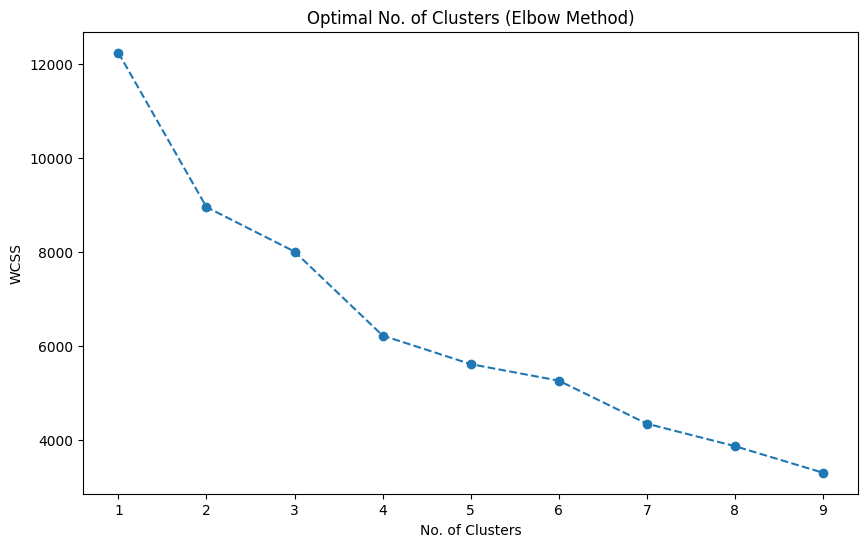

In [23]:
# Symmetry Feature set for clustering
X_symmetry = pd.get_dummies(cleaned_df[['ef', 'op', 'u/g', 'Sym']], drop_first=True)

# Elbow Method for Optimal number of Clusters
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state =42)
    kmeans.fit(X_symmetry)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--')
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')
plt.title('Optimal No. of Clusters (Elbow Method)')
plt.show()

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Apply KMeans with optimal clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_symmetry)

# Evaluate clustering
silhouette = silhouette_score(X_symmetry, clusters)
davies_bouldin = davies_bouldin_score(X_symmetry, clusters)

print(f'Silhouette Score: {silhouette:.3f}')
print(f'Davies-Bouldin Index: {davies_bouldin:.3f}')

Silhouette Score: 0.271
Davies-Bouldin Index: 1.705


### Description: 
The clustering scores indicate that clustering is not distinct and there may be some overlap between them.

In [25]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X1_train, y_train)
print("Best RF Parameters:", grid_rf.best_params_)

Best RF Parameters: {'max_depth': 20, 'n_estimators': 200}


## 2.0 Random Forest Regressor and Evaluation

In [26]:
# Initialize Random Forest Regressor
rf_model1 = RandomForestRegressor(
    n_estimators=200,  # No. of decision trees
    max_depth=20,      # depth of each tree
    random_state=42,
    n_jobs=-1          # Use all processors
)

# Train the model
rf_model1.fit(X1_train, y_train)
y_pred1_rf = rf_model1.predict(X1_test)

# Evaluate Model 1
mae1_rf = mean_absolute_error(y_test, y_pred1_rf)
mse1_rf = mean_squared_error(y_test, y_pred1_rf)
r2_1rf = r2_score(y_test, y_pred1_rf)

print("Random Forest without symmetry\n")
print(f"Mean squared error: {mae1_rf:.3f}")
print(f"Mean absolute error: {mse1_rf:.3f}")
print(f"R2: {r2_1rf:.3f}")

# Convert MAE and MSE to eV for the Random Forest model
mse1_rf_eV = (mse1_rf**0.5) * 1.2398e-4  # Square root for MSE
mae1_rf_eV = mae1_rf * 1.2398e-4  # Direct conversion for MAE
print("\nConverted Values for Random Forest without symmetry:\n")
print(f"MSE in eV: {mse1_rf_eV:.6f} eV")
print(f"MAE in eV: {mae1_rf_eV:.6f} eV")

Random Forest without symmetry

Mean squared error: 30.437
Mean absolute error: 4494.300
R2: 0.999

Converted Values for Random Forest without symmetry:

MSE in eV: 0.008312 eV
MAE in eV: 0.003774 eV


In [28]:
# Initialize Random Forest Regressor for second model
rf_model2 = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
# Train the model
rf_model2.fit(X2_train, y_train)
y_pred2_rf = rf_model2.predict(X2_test)

# Evaluate Model 2
mae2_rf = mean_absolute_error(y_test, y_pred2_rf)
mse2_rf = mean_squared_error(y_test, y_pred2_rf)
r2_2rf = r2_score(y_test, y_pred2_rf)

# Convert MAE and MSE to eV for Random Forest with Symmetry Features
mse2_rf_eV = (mse2_rf**0.5) * 1.2398e-4  # Square root for MSE
mae2_rf_eV = mae2_rf * 1.2398e-4  # Direct conversion for MAE

# Print the evaluation results and the converted values
print("\nRandom Forest with Symmetry Features\n")
print(f"Mean absolute error: {mae2_rf:.3f}")
print(f"Mean square error: {mse2_rf:.3f}")
print(f"R2: {r2_2rf:.3f}")

print("\nConverted Values in eV:\n")
print(f"MSE in eV: {mse2_rf_eV:.6f} eV")
print(f"MAE in eV: {mae2_rf_eV:.6f} eV")


Random Forest with Symmetry Features

Mean absolute error: 33.399
Mean square error: 4939.177
R2: 0.999

Converted Values in eV:

MSE in eV: 0.008713 eV
MAE in eV: 0.004141 eV


### Note on Chemical Accuracy: 
Random Forest Model also seems to perform well. However, the Kernel Regression model performs better. Although both reach the required chemical accuracy. However, symmetry does not seem to matter much in RF as adding symmetry seem to affect the fit.

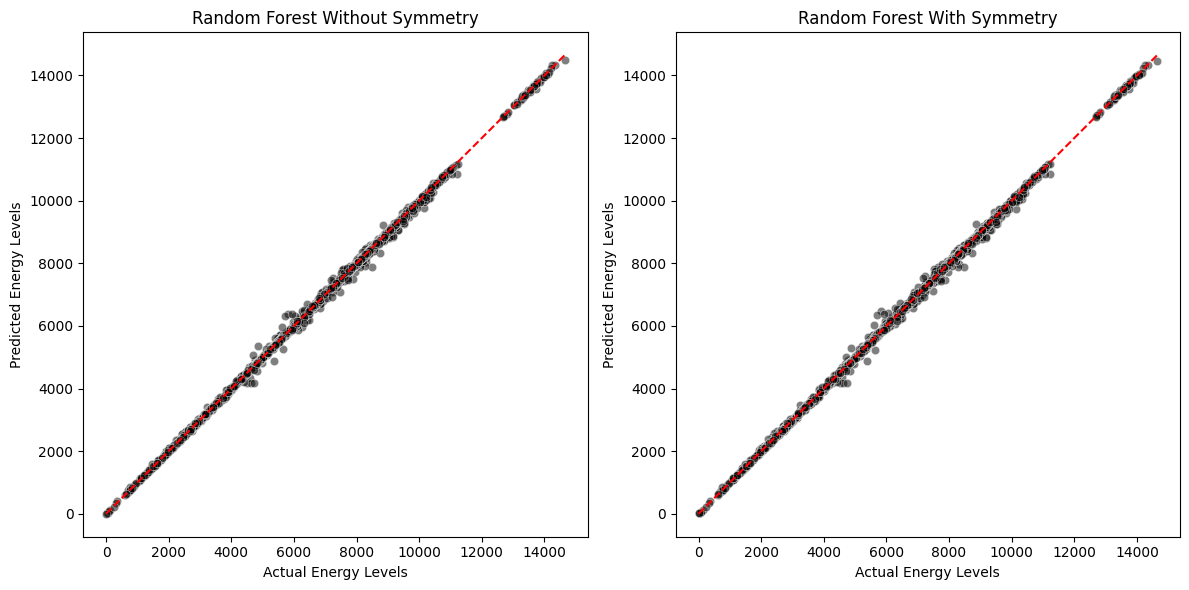

In [69]:
plt.figure(figsize=(12, 6))

# Model 1 Predictions
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred1_rf, alpha=0.5, color='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Random Forest Without Symmetry')
plt.xlabel('Actual Energy Levels')
plt.ylabel('Predicted Energy Levels')

# Model 2 Predictions
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred2_rf, alpha=0.5, color='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Random Forest With Symmetry')
plt.xlabel('Actual Energy Levels')
plt.ylabel('Predicted Energy Levels')

plt.tight_layout()
plt.show()

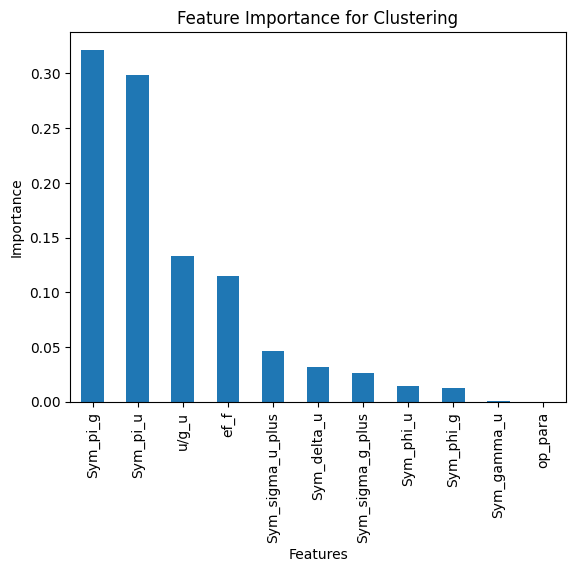

In [70]:
from sklearn.ensemble import RandomForestClassifier

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_symmetry)  # Generate cluster labels

# Train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_symmetry, clusters)  # Use the clusters as labels

# Feature Importance
feature_importances = pd.Series(rf.feature_importances_, index=X_symmetry.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance for Clustering')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

### References
1. Stack Overflow. (2022, June 1). *How to download website source files in Python?*. Retrieved from [https://stackoverflow.com/questions/72462419/how-to-download-website-source-files-in-python]
2. GeeksforGeeks. (2024, Dec 02). *Working with Missing Data in Pandas.* Retrieved from [https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/]
3. Saturn Cloud. (2023, July 10). *How to remove rows with specific values in pandas dataframe.* Retrieved from [https://saturncloud.io/blog/how-to-remove-rows-with-specific-values-in-pandas-dataframe/]
4. Scikit-learn developers. (n.d.). *Preprocessing.* Retrieved from [https://scikit-learn.org/1.5/modules/preprocessing.html]
5. GeeksforGeeks. (2024, Jun 28). *Understanding Kernel Ridge Regression with Sklearn.* Retrieved from [https://www.geeksforgeeks.org/understanding-kernel-ridge-regression-with-sklearn/]